In [1]:
import math
import numpy as np
import seaborn as sns
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import env
from pydataset import data
from scipy.stats import pearsonr, spearmanr
import scipy
import os
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
import statsmodels.api as sm
import acquire
import prepare

# Scenario
You are a junior data scientist on the Zillow data science team and recieve the following email in your inbox:

We want to be able to predict the property tax assessed values ('taxvaluedollarcnt') of Single Family Properties that had a transaction during 2017.

We have a model already, but we are hoping your insights can help us improve it. I need recommendations on a way to make a better model. Maybe you will create a new feature out of existing ones that works better, try a non-linear regression algorithm, or try to create a different model for each county. Whatever you find that works (or doesn't work) will be useful. Given you have just joined our team, we are excited to see your outside perspective.

One last thing, Zach lost the email that told us where these properties were located. Ugh, Zach :-/. Because property taxes are assessed at the county level, we would like to know what states and counties these are located in.

-- The Zillow Data Science Team



# Goals 
- Construct an ML Regression model that predict propery tax assessed values ('taxvaluedollarcnt') of Single Family Properties using attributes of the properties.

- Find the key drivers of property value for single family properties. Some questions that come to mind are: Why do some properties have a much higher value than others when they are located so close to each other? Why are some properties valued so differently from others when they have nearly the same physical attributes but only differ in location? Is having 1 bathroom worse than having 2 bedrooms?

- Deliver a report that the data science team can read through and replicate, understand what steps were taken, why and what the outcome was.

- Make recommendations on what works or doesn't work in prediction these homes' values.

# Acquiring the Data

- Information on aquiring the data can be seen in [Github.Acquire_code](https://github.com/EribertoContreras/zillow_estimating_home_value/blob/main/acquire.py), an individual with the correct credentials can repeat the process of acquiring the data and get the same results when calling on the data by using the next 3 lines of code on this jupyter notebook

In [2]:
# retrive original data set from aquire.py 
df = acquire.get_zillow_data()

In [3]:
#original shape of combined (Properties_2017, Predictions_2017, Propertylandusetype) from zillow data set.
df.shape

(52442, 63)

# Preparing The Data

[Github.Cleaning_data_code](https://github.com/EribertoContreras/zillow_estimating_home_value/blob/main/prepare.py)

In [4]:
df = prepare.clean_zillow_data(df)

In [5]:
df.taxvaluedollarcnt > 600124

0         True
1        False
2        False
3        False
4         True
         ...  
52437    False
52438    False
52439    False
52440    False
52441    False
Name: taxvaluedollarcnt, Length: 52281, dtype: bool

In [6]:
#making an extra copy.
above = df.taxvaluedollarcnt > 600124

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

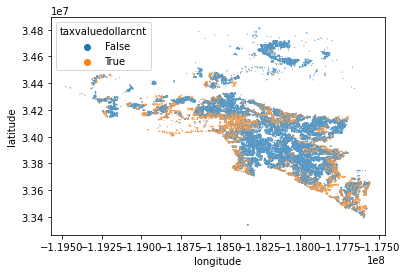

In [7]:
sns.scatterplot(df.longitude,df.latitude, s=1, hue= above)

# Area of ventura county

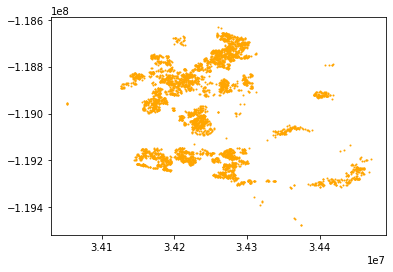

In [8]:
ventura = df[df.fips == 'Ventura,CA']
plt.scatter(ventura.latitude, ventura.longitude, s=1, c='orange')


# Area of Los Angeles county

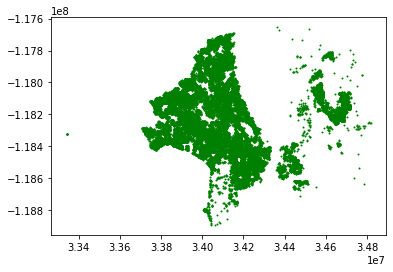

In [9]:
la = df[df.fips == 'Los Angeles,CA']
plt.scatter(la.latitude, la.longitude, s=1,c='green')

# Area of Orange county

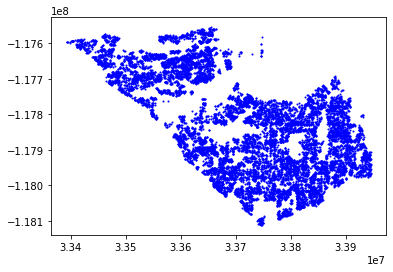

In [10]:
oc = df[df.fips == 'Orange,CA']
plt.scatter(oc.latitude, oc.longitude, s=1,c='b')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52281 entries, 0 to 52441
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   52281 non-null  float64
 1   bedroomcnt                    52281 non-null  float64
 2   calculatedfinishedsquarefeet  52281 non-null  float64
 3   fips                          52281 non-null  object 
 4   garagecarcnt                  52281 non-null  float64
 5   heatingorsystemtypeid         52281 non-null  float64
 6   latitude                      52281 non-null  float64
 7   longitude                     52281 non-null  float64
 8   regionidcity                  52281 non-null  float64
 9   regionidcounty                52281 non-null  float64
 10  regionidzip                   52281 non-null  float64
 11  yearbuilt                     52281 non-null  float64
 12  taxvaluedollarcnt             52281 non-null  float64
 13  l

In [12]:
#Spliting my data
train, validate, test = prepare.split_zillow_data(df)

# Scaling CalculatedFinishedSquarefeet

In [13]:
print('train shape: %d x %d' % train.shape)
print('test shape: %d x %d' % test.shape)
train.head()

train shape: 29276 x 15
test shape: 10457 x 15


,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,garagecarcnt,heatingorsystemtypeid,latitude,longitude,regionidcity,regionidcounty,regionidzip,yearbuilt,taxvaluedollarcnt,logerror,propertylandusedesc
25465,4.5,5.0,6078.0,"Orange,CA",3.0,0.0,33562738.0,-117689004.0,25458.0,1286.0,96971.0,1989.0,2278176.0,0.066377,Single Family Residential
17993,3.0,4.0,1226.0,"Los Angeles,CA",0.0,7.0,33901070.0,-118048049.0,53636.0,3101.0,96193.0,1950.0,245974.0,-0.011585,Single Family Residential
9027,2.0,2.0,1074.0,"Los Angeles,CA",0.0,7.0,33927757.0,-118247688.0,118994.0,3101.0,96040.0,1909.0,275822.0,0.190972,Single Family Residential
31427,1.0,2.0,761.0,"Los Angeles,CA",0.0,7.0,34050086.0,-118101577.0,54212.0,3101.0,96510.0,1947.0,245836.0,0.166579,Single Family Residential
4201,2.0,3.0,1442.0,"Los Angeles,CA",0.0,7.0,34188751.0,-118515293.0,12447.0,3101.0,96415.0,1950.0,404537.0,-0.041500,Single Family Residential


In [14]:
scaler, train_scaled, validate_scaled, test_scaled = prepare.scale_data(train, validate, test, return_scaler=True)

In [15]:
train_scaled

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,garagecarcnt,heatingorsystemtypeid,latitude,longitude,regionidcity,regionidcounty,regionidzip,yearbuilt,taxvaluedollarcnt,logerror,propertylandusedesc
25465,0.35,0.363636,0.272122,"Orange,CA",0.214286,0.00,0.150135,0.930040,0.064198,0.0,0.242625,0.986607,0.089722,0.476064,Single Family Residential
17993,0.20,0.272727,0.049318,"Los Angeles,CA",0.000000,0.35,0.379060,0.743098,0.135255,1.0,0.240678,0.967262,0.009652,0.468203,Single Family Residential
9027,0.10,0.090909,0.042338,"Los Angeles,CA",0.000000,0.35,0.397117,0.639154,0.300069,1.0,0.240295,0.946925,0.010828,0.488625,Single Family Residential
31427,0.00,0.090909,0.027965,"Los Angeles,CA",0.000000,0.35,0.479889,0.715228,0.136707,1.0,0.241471,0.965774,0.009647,0.486166,Single Family Residential
4201,0.10,0.181818,0.059237,"Los Angeles,CA",0.000000,0.35,0.573713,0.499822,0.031388,1.0,0.241234,0.967262,0.015900,0.465187,Single Family Residential
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30318,0.20,0.181818,0.084768,"Orange,CA",0.142857,0.00,0.134216,0.883739,0.133252,0.0,0.242620,0.966270,0.025174,0.464710,Single Family Residential
27186,0.20,0.272727,0.099646,"Los Angeles,CA",0.000000,0.10,0.515150,0.581306,0.031388,1.0,0.240263,0.952877,0.041682,0.452372,Single Family Residential
20241,0.10,0.181818,0.060982,"Los Angeles,CA",0.000000,0.35,0.337109,0.596397,0.137993,1.0,0.240598,0.967758,0.003875,0.472254,Single Family Residential
47423,0.00,0.090909,0.073610,"Los Angeles,CA",0.000000,0.10,0.559123,0.744115,0.120273,1.0,0.240891,0.954861,0.015638,0.467288,Single Family Residential


# DATA EXPLORATION

## Working on Our Most Valuable Payers that affect TaxValueDollarCount

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29276 entries, 25465 to 2454
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   29276 non-null  float64
 1   bedroomcnt                    29276 non-null  float64
 2   calculatedfinishedsquarefeet  29276 non-null  float64
 3   fips                          29276 non-null  object 
 4   garagecarcnt                  29276 non-null  float64
 5   heatingorsystemtypeid         29276 non-null  float64
 6   latitude                      29276 non-null  float64
 7   longitude                     29276 non-null  float64
 8   regionidcity                  29276 non-null  float64
 9   regionidcounty                29276 non-null  float64
 10  regionidzip                   29276 non-null  float64
 11  yearbuilt                     29276 non-null  float64
 12  taxvaluedollarcnt             29276 non-null  float64
 13

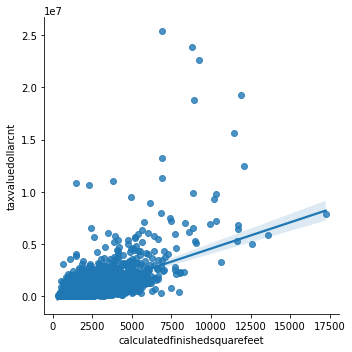

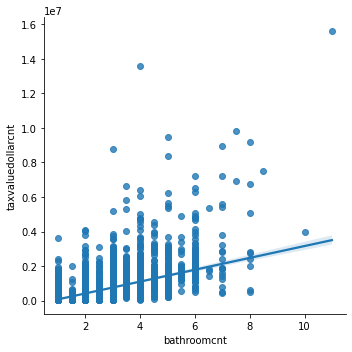

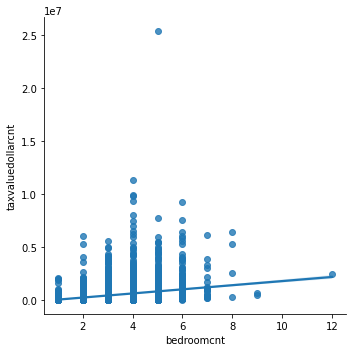

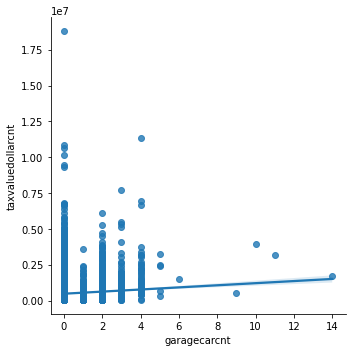

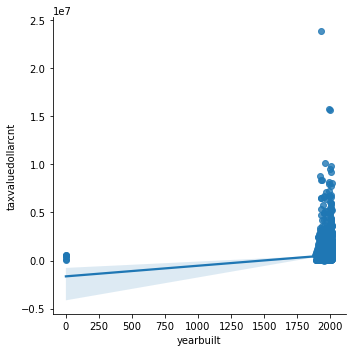

In [17]:
prepare.plot_variable_pairs(train)

<AxesSubplot:xlabel='bathroomcnt', ylabel='taxvaluedollarcnt'>

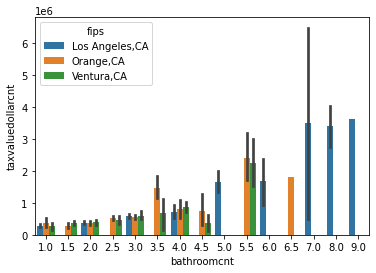

In [18]:
sns.barplot(x = 'bathroomcnt', y='taxvaluedollarcnt', hue = 'fips',data=train.sample(1000))

<AxesSubplot:>

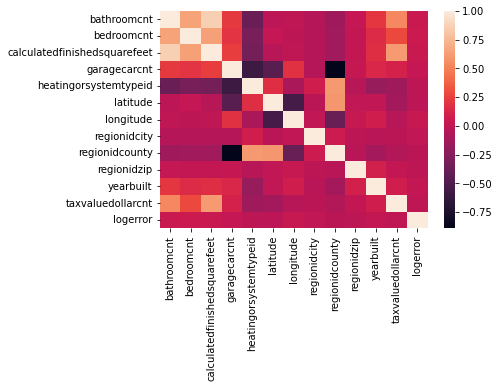

In [19]:
sns.heatmap(train.corr())

In [20]:
train.describe()[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'taxvaluedollarcnt']]

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt
count,29276.000000,29276.000000,29276.000000,2.927600e+04
mean,2.308017,3.308375,1925.951223,5.290586e+05
std,1.018634,0.941572,1009.430384,7.277707e+05
min,1.000000,1.000000,152.000000,1.000000e+03
25%,2.000000,3.000000,1263.000000,1.926070e+05
50%,2.000000,3.000000,1660.000000,3.732855e+05
75%,3.000000,4.000000,2315.250000,6.206830e+05
max,11.000000,12.000000,21929.000000,2.538125e+07


- Calculatedfinishedsqaurefeet has a large differance that has a significant affect on TaxValuedollarcount
- Bathroomcnt has a differance that has a moderate significant affect on TaxValuedollarcount
- Bedroomcnt has a differance that has a moderate significant affect on TaxValuedollarcount

well be focusing on calculatedfinishedsquarefeet, bathroomcnt, bedroomcnt

# Hypothesis testing

In [21]:
alpha = 0.05

In [22]:
corr, p = stats.pearsonr(train.calculatedfinishedsquarefeet, train.taxvaluedollarcnt)
corr, p

(0.615639734032053, 0.0)

In [23]:
p < alpha

True

In [24]:
train.describe()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,garagecarcnt,heatingorsystemtypeid,latitude,longitude,regionidcity,regionidcounty,regionidzip,yearbuilt,taxvaluedollarcnt,logerror
count,29276.000000,29276.000000,29276.000000,29276.000000,29276.000000,2.927600e+04,2.927600e+04,29276.000000,29276.000000,29276.000000,29276.000000,2.927600e+04,29276.000000
mean,2.308017,3.308375,1925.951223,0.676663,2.551407,3.402045e+07,-1.181905e+08,32654.060152,2518.391720,96611.715125,1962.103873,5.290586e+05,0.018598
std,1.018634,0.941572,1009.430384,0.985069,2.791567,2.756491e+05,3.549699e+05,48217.308023,807.484913,5761.816706,57.439316,7.277707e+05,0.182465
min,1.000000,1.000000,152.000000,0.000000,0.000000,3.334085e+07,-1.194753e+08,0.000000,1286.000000,0.000000,0.000000,1.000000e+03,-4.655420
25%,2.000000,3.000000,1263.000000,0.000000,0.000000,3.382355e+07,-1.183981e+08,12447.000000,1286.000000,96206.000000,1950.000000,1.926070e+05,-0.024357
50%,2.000000,3.000000,1660.000000,0.000000,2.000000,3.402032e+07,-1.181507e+08,24384.000000,3101.000000,96414.000000,1961.000000,3.732855e+05,0.007140
75%,3.000000,4.000000,2315.250000,2.000000,2.000000,3.418677e+07,-1.179273e+08,40227.000000,3101.000000,96995.000000,1979.000000,6.206830e+05,0.040359
max,11.000000,12.000000,21929.000000,14.000000,20.000000,3.481877e+07,-1.175546e+08,396556.000000,3101.000000,399675.000000,2016.000000,2.538125e+07,5.262999


***

In [25]:
zillow_corr = train.drop(columns=['taxvaluedollarcnt']).corr()
zillow_corr


,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,garagecarcnt,heatingorsystemtypeid,latitude,longitude,regionidcity,regionidcounty,regionidzip,yearbuilt,logerror
bathroomcnt,1.000000,0.650905,0.854737,0.219596,-0.380503,-0.014536,-0.004250,-0.051744,-0.140723,0.017056,0.202849,0.039599
bedroomcnt,0.650905,1.000000,0.636736,0.198729,-0.312731,0.017220,-0.006369,-0.045864,-0.137081,0.010233,0.154522,0.050188
calculatedfinishedsquarefeet,0.854737,0.636736,1.000000,0.235391,-0.326707,-0.039714,-0.004379,-0.048617,-0.138094,0.011711,0.170098,0.044934
garagecarcnt,0.219596,0.198729,0.235391,1.000000,-0.581797,-0.453939,0.181325,-0.049057,-0.892107,0.029056,0.133589,0.024208
heatingorsystemtypeid,-0.380503,-0.312731,-0.326707,-0.581797,1.000000,0.170353,-0.088111,0.077141,0.604480,-0.036886,-0.179551,-0.010530
latitude,-0.014536,0.017220,-0.039714,-0.453939,0.170353,1.000000,-0.549385,-0.023921,0.596203,0.004774,0.002848,-0.017873
longitude,-0.004250,-0.006369,-0.004379,0.181325,-0.088111,-0.549385,1.000000,0.005750,-0.386748,0.038011,0.083200,0.031810
regionidcity,-0.051744,-0.045864,-0.048617,-0.049057,0.077141,-0.023921,0.005750,1.000000,0.054956,-0.005259,-0.030499,0.004138
regionidcounty,-0.140723,-0.137081,-0.138094,-0.892107,0.604480,0.596203,-0.386748,0.054956,1.000000,-0.033494,-0.129783,-0.022852
regionidzip,0.017056,0.010233,0.011711,0.029056,-0.036886,0.004774,0.038011,-0.005259,-0.033494,1.000000,0.091861,-0.005201


# Evaluating regression models

In [26]:
from sklearn.linear_model import LinearRegression
y = pd.DataFrame(train.taxvaluedollarcnt)
X = pd.DataFrame(train.calculatedfinishedsquarefeet)
# assuming X and y are already defined
model = LinearRegression().fit(X, y)
train['yhat'] = model.predict(X)
train

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,garagecarcnt,heatingorsystemtypeid,latitude,longitude,regionidcity,regionidcounty,regionidzip,yearbuilt,taxvaluedollarcnt,logerror,propertylandusedesc,yhat
25465,4.5,5.0,6078.0,"Orange,CA",3.0,0.0,33562738.0,-117689004.0,25458.0,1286.0,96971.0,1989.0,2278176.0,0.066377,Single Family Residential,2.371982e+06
17993,3.0,4.0,1226.0,"Los Angeles,CA",0.0,7.0,33901070.0,-118048049.0,53636.0,3101.0,96193.0,1950.0,245974.0,-0.011585,Single Family Residential,2.183791e+05
9027,2.0,2.0,1074.0,"Los Angeles,CA",0.0,7.0,33927757.0,-118247688.0,118994.0,3101.0,96040.0,1909.0,275822.0,0.190972,Single Family Residential,1.509126e+05
31427,1.0,2.0,761.0,"Los Angeles,CA",0.0,7.0,34050086.0,-118101577.0,54212.0,3101.0,96510.0,1947.0,245836.0,0.166579,Single Family Residential,1.198475e+04
4201,2.0,3.0,1442.0,"Los Angeles,CA",0.0,7.0,34188751.0,-118515293.0,12447.0,3101.0,96415.0,1950.0,404537.0,-0.041500,Single Family Residential,3.142526e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30318,3.0,3.0,1998.0,"Orange,CA",2.0,0.0,33539211.0,-117777930.0,52842.0,1286.0,96969.0,1948.0,639922.0,-0.046230,Single Family Residential,5.610381e+05
27186,3.0,4.0,2322.0,"Los Angeles,CA",0.0,2.0,34102199.0,-118358792.0,12447.0,3101.0,96027.0,1921.0,1058894.0,-0.168608,Single Family Residential,7.048483e+05
20241,2.0,3.0,1480.0,"Los Angeles,CA",0.0,7.0,33839070.0,-118329807.0,54722.0,3101.0,96161.0,1951.0,99356.0,0.028592,Single Family Residential,3.311192e+05
47423,1.0,2.0,1755.0,"Los Angeles,CA",0.0,2.0,34167188.0,-118046096.0,47695.0,3101.0,96278.0,1925.0,397897.0,-0.020666,Single Family Residential,4.531804e+05


In [27]:
df = pd.DataFrame(train[['calculatedfinishedsquarefeet','taxvaluedollarcnt','yhat']])
df.head()

,calculatedfinishedsquarefeet,taxvaluedollarcnt,yhat
25465,6078.0,2278176.0,2.371982e+06
17993,1226.0,245974.0,2.183791e+05
9027,1074.0,275822.0,1.509126e+05
31427,761.0,245836.0,1.198475e+04
4201,1442.0,404537.0,3.142526e+05


In [28]:
#creating a baseline from the mean of the target variable
baseline = y.mean()
df['baseline'] = y.taxvaluedollarcnt.mean()
# turning baseline to int from float
df.baseline = df.baseline.astype(int)
# residual = actual - predicted
df['residual'] = df.taxvaluedollarcnt - df.yhat
df['baseline_residual'] = df.taxvaluedollarcnt - df.baseline

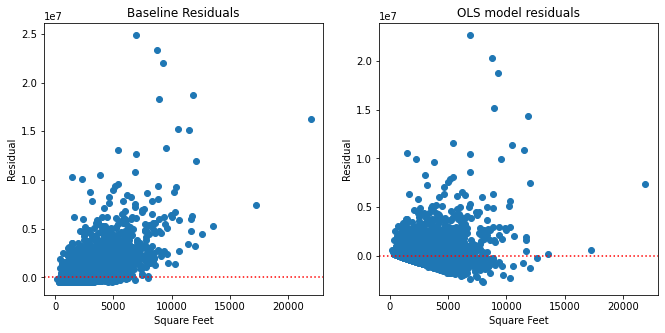

In [29]:
# residual plots (x vs residual)

plt.figure(figsize = (11,5))

plt.subplot(121)
plt.scatter(df.calculatedfinishedsquarefeet, df.baseline_residual)
plt.axhline(y = 0, ls = ':', color='red')
plt.xlabel('Square Feet')
plt.ylabel('Residual')
plt.title('Baseline Residuals')

plt.subplot(122)
plt.scatter(df.calculatedfinishedsquarefeet, df.residual)
plt.axhline(y = 0, ls = ':', color ='red')
plt.xlabel('Square Feet')
plt.ylabel('Residual')
plt.title('OLS model residuals');


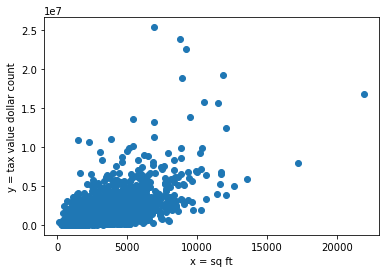

In [30]:
y = pd.DataFrame(df.taxvaluedollarcnt)
X = pd.DataFrame(df.calculatedfinishedsquarefeet)
# look at scatter of x vs y
plt.scatter(X, y)
plt.xlabel('x = sq ft')
plt.ylabel('y = tax value dollar count');

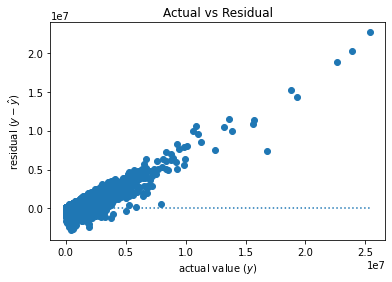

In [31]:
# Residual plot (y vs residual)
actual = df.taxvaluedollarcnt
predicted = df.yhat
residuals = actual - predicted
plt.hlines(0, actual.min(), actual.max(), ls=':')
plt.scatter(actual, residuals)
plt.ylabel('residual ($y - \hat{y}$)')
plt.xlabel('actual value ($y$)')
plt.title('Actual vs Residual')
plt.show()


In [32]:
# sum of residual is zero
df.residual.sum()

-6.742775440216064e-07

In [33]:
# sum of baseline residual is zero too
df.baseline_residual.sum()

17802.0

In [34]:
df['residual^2'] = df.residual**2
df['baseline_residual^2'] = df.baseline_residual**2

df.head()

,calculatedfinishedsquarefeet,taxvaluedollarcnt,yhat,baseline,residual,baseline_residual,residual^2,baseline_residual^2
25465,6078.0,2278176.0,2.371982e+06,529058,-93806.026803,1749118.0,8.799571e+09,3.059414e+12
17993,1226.0,245974.0,2.183791e+05,529058,27594.906975,-283084.0,7.614789e+08,8.013655e+10
9027,1074.0,275822.0,1.509126e+05,529058,124909.445708,-253236.0,1.560237e+10,6.412847e+10
31427,761.0,245836.0,1.198475e+04,529058,233851.252442,-283222.0,5.468641e+10,8.021470e+10
4201,1442.0,404537.0,3.142526e+05,529058,90284.404564,-124521.0,8.151274e+09,1.550548e+10


In [35]:
SSE = df['residual^2'].sum()
SSE_baseline = df['baseline_residual^2'].sum()

print('SSE =', "{:.1f}".format(SSE))
print("SSE Baseline =", "{:.1f}".format(SSE_baseline))

if SSE < SSE_baseline:
    print('SSE is better than baseline')
else:
    print('baseline is better')

SSE = 9628731139190622.0
SSE Baseline = 15505509790200684.0
SSE is better than baseline


In [36]:
len(df)
df.shape[0]

29276

In [37]:
MSE = SSE/len(df)
MSE_baseline = SSE_baseline/len(df)

print("MSE = ", "{:.1f}".format(MSE))
print("MSE baseline = ", "{:.1f}".format(MSE_baseline))

if MSE < MSE_baseline:
    print('MSE is better than baseline')
else:
    print('baseline is better')

MSE =  328895038228.9
MSE baseline =  529632114708.3
MSE is better than baseline


In [38]:
from math import sqrt
RMSE = sqrt(MSE)
RMSE_baseline =  sqrt(MSE_baseline)

if RMSE < RMSE_baseline:
    print('RMSE is better than baseline')
else:
    print('baseline is better')
    
print("RMSE = ", "{:.1f}".format(RMSE))
print("RMSE baseline = ", "{:.1f}".format(RMSE_baseline))

RMSE is better than baseline
RMSE =  573493.7
RMSE baseline =  727758.3


In [39]:
if SSE < SSE_baseline:
    print('OLS regression model performs better than the baseline')
else:
    print('OLS regression model performs worse than the baseline')

OLS regression model performs better than the baseline


In [40]:
# calculate R2 the easy way:
from sklearn.metrics import r2_score
r2_score(df.taxvaluedollarcnt, df.yhat)

0.3790122821190567

In [41]:
X2 = sm.add_constant(df.calculatedfinishedsquarefeet)
est = sm.OLS(df.taxvaluedollarcnt, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:      taxvaluedollarcnt   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                 1.787e+04
Date:                Tue, 07 Jun 2022   Prob (F-statistic):               0.00
Time:                        17:02:20   Log-Likelihood:            -4.2973e+05
No. Observations:               29276   AIC:                         8.595e+05
Df Residuals:                   29274   BIC:                         8.595e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [42]:
X2 = sm.add_constant(df.)
est = sm.OLS(df.taxvaluedollarcnt, X2)
est2 = est.fit()
print(est2.summary())

SyntaxError: invalid syntax (1339344194.py, line 1)

In [ ]:
def residuals(actual, predicted):
    return actual - predicted

#sum of squared errors (SSE)
def sse(actual, predicted):
    return (residuals(actual, predicted) **2).sum()

#explained sum of squares (ESS)
def ess(actual, predicted):
    return ((predicted - actual.mean()) ** 2).sum()

#total sum of squares (TSS)
def tss(actual):
    return ((actual - actual.mean()) ** 2).sum()

#mean squared error (MSE)
def mse(actual, predicted):
    n = actual.shape[0]
    return sse(actual, predicted) / n

#root mean squared error (RMSE)
def rmse(actual, predicted):
    return math.sqrt(mse(actual, predicted))

# returns r2 score
def r2_score(actual, predicted):
    return ess(actual, predicted) / tss(actual)
#_____________________________________________________________________________________
def regression_errors(actual, predicted):
    return pd.Series({
        'SSE': sse(actual, predicted),
        'ESS': ess(actual, predicted),
        'TSS': tss(actual),
        'MSE': mse(actual, predicted),
        'RMSE': rmse(actual, predicted),
    })

def baseline_mean_errors(actual):
    predicted = actual.mean()
    return {
        'SSE': sse(actual, predicted),
        'MSE': mse(actual, predicted),
        'RMSE': rmse(actual, predicted),
    }

def better_than_baseline(actual, predicted):
    rmse_baseline = rmse(actual, actual.mean())
    rmse_model = rmse(actual, predicted)
    return rmse_model < rmse_baseline

In [ ]:
regression_errors(actual,predicted)

In [ ]:
baseline_mean_errors(actual)

In [ ]:
better_than_baseline(actual, predicted)

***

# Modeling

In [ ]:
X_train = train[['calculatedfinishedsquarefeet']]
y_train = train['taxvaluedollarcnt']

X_validate = validate[['calculatedfinishedsquarefeet']]
y_validate = validate['taxvaluedollarcnt']

X_test = test[['calculatedfinishedsquarefeet']]
y_test = test['taxvaluedollarcnt']

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values.
y_train = pd.DataFrame(train.taxvaluedollarcnt)
y_validate = pd.DataFrame(validate.taxvaluedollarcnt)
# 1. Predict price_pred_mean
price_pred_mean = y_train['taxvaluedollarcnt'].mean()
y_train['price_pred_mean'] = price_pred_mean
y_validate['price_pred_mean'] = price_pred_mean
# 2. compute price_pred_median
price_pred_median = y_train['taxvaluedollarcnt'].median()
y_train['price_pred_median'] = price_pred_median
y_validate['price_pred_median'] = price_pred_median
# 3. RMSE of price_pred_mean
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.price_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.price_pred_mean)**(1/2)
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2),
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))
# 4. RMSE of taxvaluedollarcnt_pred_median
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.price_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.price_pred_median)**(1/2)
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2),
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))